In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from scipy.stats import invwishart

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

In [34]:
def gaussian_entropy(sigma):
    return 0.5 * D * (1.0 + torch.log(2*torch.tensor(np.pi))) + torch.sum(torch.log(sigma))

# Variational Distribution #

In [4]:
D = 13

In [5]:
q = MeanFieldVariationalDistribution(D, mu=-3.0, sigma=3.0)

# Posterior #

In [6]:
S = invwishart.rvs(D, np.identity(D))

In [7]:
def logposterior(x):
    return torch.distributions.multivariate_normal.MultivariateNormal(torch.ones([1,D]), covariance_matrix=torch.tensor(S).float()).log_prob(x).unsqueeze(-1)

In [8]:
import pylab as plt
import numpy as np
T = 100
# Sample data
side = np.linspace(-5,5,T)
X,Y = np.meshgrid(side,side)

In [9]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x))

RuntimeError: The size of tensor a (2) must match the size of tensor b (13) at non-singleton dimension 1

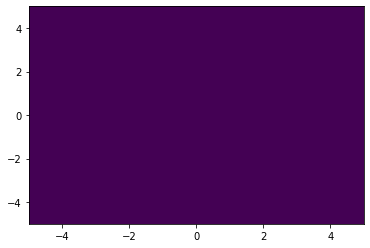

In [10]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [11]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x)) + q.log_prob(x).exp()

RuntimeError: The size of tensor a (2) must match the size of tensor b (250) at non-singleton dimension 1

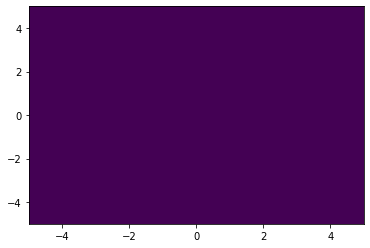

In [12]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [10]:
n_samples_ELBO = 1000

In [11]:
q.mu.detach_().requires_grad_()
q.rho.detach_().requires_grad_()

optimizer = torch.optim.Adam(q.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

In [12]:
z = q.sample(n_samples_ELBO)

In [13]:
LQ = q.log_prob(z)
LQ

tensor([[-30.3409],
        [-30.8297],
        [-30.7649],
        [-36.3215],
        [-36.0434],
        [-31.8607],
        [-31.7226],
        [-33.3497],
        [-33.3041],
        [-30.5690],
        [-33.4940],
        [-29.7788],
        [-32.9763],
        [-34.4301],
        [-33.2705],
        [-32.7723],
        [-31.1136],
        [-35.4038],
        [-29.8501],
        [-29.5290],
        [-33.9498],
        [-31.9771],
        [-37.1492],
        [-32.0345],
        [-34.9604],
        [-30.7455],
        [-30.4922],
        [-32.3098],
        [-31.6486],
        [-32.8007],
        [-31.1245],
        [-28.0367],
        [-31.7014],
        [-35.7321],
        [-33.5329],
        [-31.4620],
        [-30.6476],
        [-32.9728],
        [-33.9507],
        [-30.9090],
        [-34.0845],
        [-32.3587],
        [-34.3320],
        [-29.5265],
        [-29.7518],
        [-38.6281],
        [-30.4301],
        [-31.2543],
        [-40.7826],
        [-31.2119],


In [15]:
LP = logposterior(z)
LP

tensor([[-2345.0173],
        [-1777.8267],
        [-1965.3336],
        [-2748.2947],
        [-2805.9482],
        [-2232.3650],
        [-3503.7764],
        [-3318.6379],
        [-1907.5958],
        [-3723.6653],
        [-1970.6375],
        [-1767.7446],
        [-1795.9248],
        [-2809.0784],
        [-2598.6624],
        [-2073.5549],
        [-2562.8721],
        [ -349.8397],
        [-2533.7483],
        [-2509.7036],
        [-1123.8632],
        [-2599.2766],
        [-4421.2852],
        [-2109.9060],
        [-2978.0232],
        [-1372.7322],
        [-2431.0088],
        [-1796.2513],
        [-2019.5225],
        [-3443.8086],
        [-2509.0315],
        [-2063.9431],
        [-1830.1915],
        [-1773.7748],
        [-3556.1926],
        [-1697.6766],
        [-2867.9297],
        [-3039.2241],
        [-3045.0693],
        [-1492.6218],
        [-2193.4243],
        [-2894.9185],
        [-3692.0330],
        [-1819.1431],
        [-1533.7076],
        [-

In [35]:
gaussian_entropy(q.sigma)

tensor(32.7282, grad_fn=<AddBackward0>)

In [24]:
D = q.sigma.shape[0]

In [29]:
0.5 * D * (1.0 + torch.log(2*torch.tensor(np.pi)))

tensor(18.4462)

In [31]:
torch.log(q.sigma)

tensor([1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986, 1.0986,
        1.0986, 1.0986, 1.0986, 1.0986], grad_fn=<LogBackward>)

In [20]:
return 




torch.Size([13])

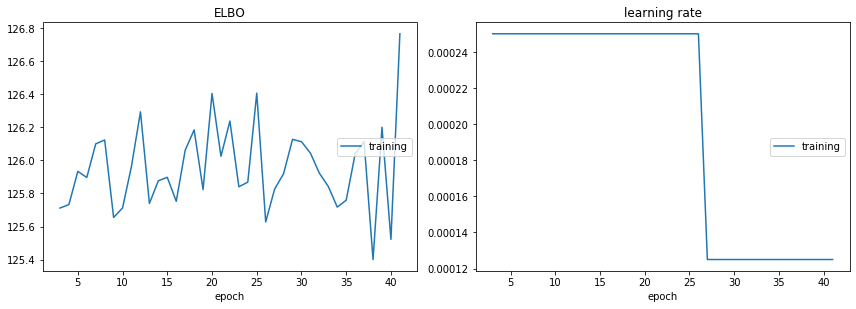

ELBO:
training   (min:  125.401, max:  126.764, cur:  126.764)

learning rate:
training   (min:    0.000, max:    0.000, cur:    0.000)


KeyboardInterrupt: 

In [31]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break
        

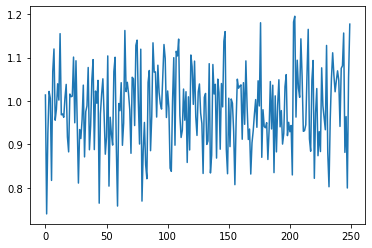

In [30]:
plt.plot(q.mu.detach().cpu().numpy())